# **Bisphosphine ligand feature space design and ligand selection**

## 0. Imports

Code for the development of PCA and t-SNE bisphosphine feature spaces and selection of ligands for computational investigations.

In [1]:
import pandas as pd
import numpy as np
import openpyxl

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from autoelbow_rupakbob import autoelbow

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

from pathlib import Path

from functions.plotting import plot_features

/var/folders/q_/pxh8rpm1021bvcmqb5qg17p00000gn/T/ipykernel_43401/3139905057.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Set default plotting parameters.

In [2]:
paramsscreen = {'backend': 'ps',
            'axes.labelsize': 15,
           'legend.fontsize': 15,
           'xtick.labelsize': 13,
           'ytick.labelsize': 13,
           'axes.titlesize': 16}

plt.rcParams.update(paramsscreen)

Define paths to features and pre-made feature space files. _Note: end users are encouraged to use the pre-generated feature spaces in the `./features_space_files` directory for reproducibility - skip to Section 5._

In [3]:
features_path = Path("./feature_files")
feature_space_path = Path("./feature_space_files")

## 1. Load free ligand features

Using curated feature list from the original bisphosphine ligand feature set previously published by our group (DOI: [10.1021/jacs.2c08513](https://doi.org/10.1021/jacs.2c08513)). Where possible free ligand features were used in preference to Pd complex features. The full list of curated features used in this study can be found in the `bisphosphine_lib_github_free.xlsx` Excel spreadsheet.

In [4]:
df = pd.read_excel(features_path / "bisphosphine_lib_github_free.xlsx", "all_C2v", index_col=0, header=1, engine="openpyxl")
features = df[df.columns[1:]].loc[df.index[0:]]
features.index = features.index.astype(int)
features.dropna(axis=0, inplace=True)

features.head()

,NoPd_R_NBO_min,NoPd_R_NBO_max,NoPd_R_NBO_avg,NoPd_Rback_NBO_min,NoPd_Rback_NBO_max,NoPd_Rback_NBO_avg,NoPd_P_NMR_min,NoPd_P_NMR_max,NoPd_P_NMR_avg,NoPd_aniso_P_NMR_min,...,bite_angle,NoPd_Homo,NoPd_Lumo,NoPd_dipole,pol,Vbur%_3.0_Ang,Vbur%_4.0_Ang,Vbur%_5.0_Ang,Vbur%_6.0_Ang,Vbur%_7.0_Ang
Ligand_ID,,,,,,,,,,,,,,,,,,,,,
8,-0.34125,-0.31732,-0.330110,-0.72203,-0.70700,-0.714515,312.1456,314.8549,313.50025,51.6072,...,97.362435,-0.19741,-0.03598,1.4598,453.32,54.371834,54.595463,51.852078,45.412264,36.538429
10,-0.47663,-0.46551,-0.472957,-0.31567,-0.31541,-0.315540,303.8823,313.7372,308.80975,63.2804,...,88.758311,-0.17599,-0.03111,1.7517,342.79,57.540599,59.592437,56.425018,47.141594,33.130269
12,-0.33929,-0.28866,-0.312202,-0.48143,-0.29423,-0.387830,292.8097,299.7692,296.28945,28.1574,...,98.393806,-0.21170,-0.07060,4.0668,624.49,62.135913,63.715008,61.635158,56.091773,47.585433
14,-0.32679,-0.31583,-0.321230,-0.34956,-0.33674,-0.343150,302.0390,313.7735,307.90625,33.3123,...,102.395428,-0.23134,-0.08159,4.0201,795.29,57.826468,58.316523,58.162586,57.212799,54.091570
16,-0.33863,-0.28685,-0.313812,-0.47879,-0.28835,-0.383570,292.7226,304.8875,298.80505,19.6218,...,97.091120,-0.20083,-0.07033,3.1133,716.98,63.706794,65.046785,63.394997,57.937888,50.120259


## 2. Prepare data

Remove colinear features using the Pearson correlation coefficient.

In [5]:
cutoff = 0.95

print(f"Number of features before curation: {features.shape[1]}")
df_corr = features.corr()

df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > cutoff).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
features = features[un_corr_idx]
print(f"Number of features after curation: {features.shape[1]}")

Number of features before curation: 91
Number of features after curation: 74


Scale features using the scikit-learn `StandardScaler`.

In [6]:
scaler = StandardScaler()
scaler.fit(features)
scaled_features = scaler.transform(features)

## 3. Dimensionality reduction

### 3.1. *t*-Distributed stochastic neighbor embedding (*t*-SNE)

Run *t*-SNE.

In [7]:
tsne_reducer = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=10)
tsne_reduced_features = tsne_reducer.fit_transform(scaled_features)

Add *t*-SNE coordinates to features dataframe.

In [8]:
features['TSNE1'] = tsne_reduced_features[:, 0]
features['TSNE2'] = tsne_reduced_features[:, 1]

Plot resultant feature space.

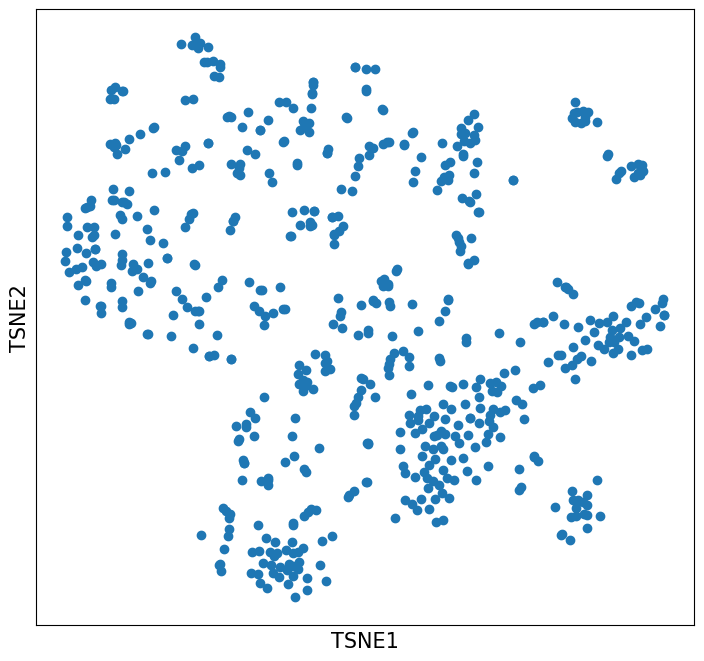

In [19]:
plot_features.plot_tsne(features['TSNE1'], features['TSNE2'])

### 3.2. Principal component analysis (PCA)

Run PCA.

In [10]:
pca_reducer = PCA(n_components=5)
pca_reducer.fit(scaled_features)

pca_reduced_features = pca_reducer.transform(scaled_features)
pca_score = pca_reducer.explained_variance_ratio_

print(f"Total variance explained by PCs: {round(np.sum(pca_score*100), 1)}%\n")
print("Percentage of explained variance per principal component:")
for i, j in enumerate(pca_score):
    print(f"PC{i+1}     {j*100:.1f}%")

Total variance explained by PCs: 67.0%

Percentage of explained variance per principal component:
PC1     20.6%
PC2     17.5%
PC3     13.5%
PC4     9.1%
PC5     6.2%


Add PCA coordinates to features dataframe.

In [11]:
features['PC1'] = pca_reduced_features[:, 0]
features['PC2'] = pca_reduced_features[:, 1]
features['PC3'] = pca_reduced_features[:, 2]
features['PC4'] = pca_reduced_features[:, 3]
features['PC5'] = pca_reduced_features[:, 4]

Plot resultant feature space.

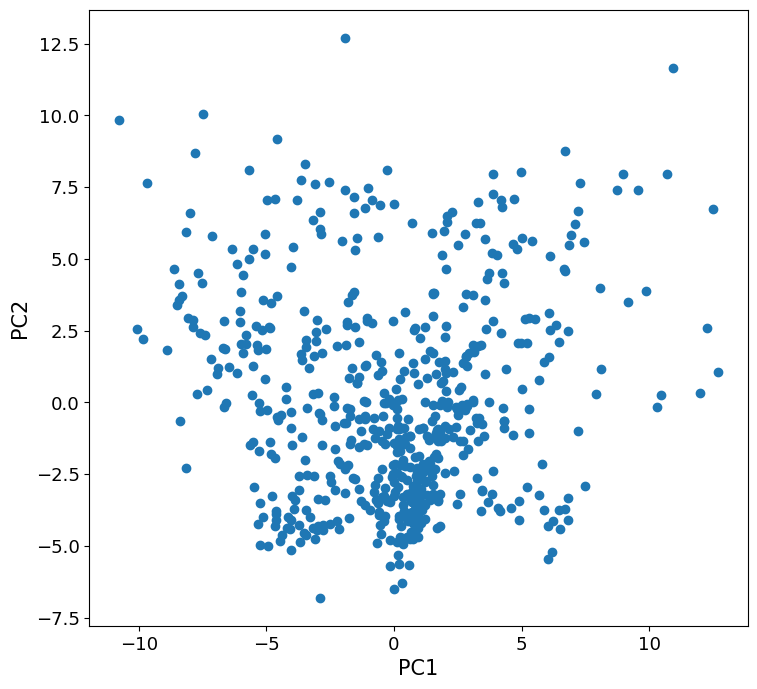

In [12]:
plot_features.plot_pca(features['PC1'], features['PC2'])

Save *t*-SNE and PCA coordinates with features to a CSV file.

In [ ]:
features.to_csv(feature_space_path / "features_tsne_pca.csv")

## 4. Clustering of feature space

Read in *t*-SNE and PCA coordinates with features. _Note: Again, end users are encouraged to use the pre-generated feature spaces and clustering in the `./features_space_files` directory for reproducibility - skip to Section 5._

In [13]:
feature_space = pd.read_csv(feature_space_path / "features_tsne_pca.csv", index_col=0)

### 4.1 Ward clustering of *t*-SNE space

In [14]:
tsne_coordinates = feature_space[['TSNE1', 'TSNE2']]

Silhouette score.

Number of clusters with max silhouette score: 8


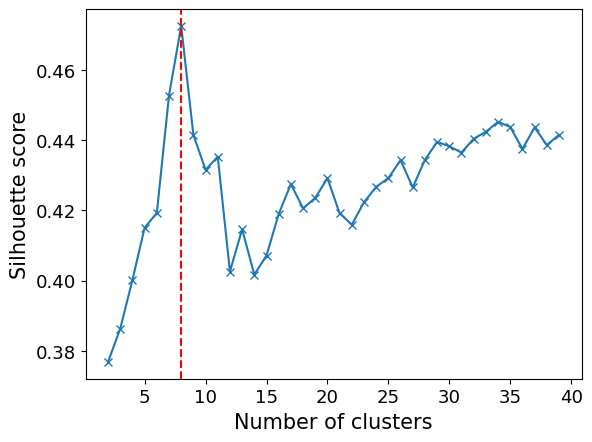

In [15]:
n_cluster = []
scores = []

range_n_clusters = range(2,40)

for i in range_n_clusters:
    n_cluster.append(i)
    z = linkage(tsne_coordinates, method='ward')
    scores.append(silhouette_score(tsne_coordinates, fcluster(z, i, criterion='maxclust')))

print(f"Number of clusters with max silhouette score: {scores.index(max(scores))+2}")

plt.plot(n_cluster, scores, 'x-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.axvline(x=scores.index(max(scores))+2, linestyle='--', color='red')
plt.show()

Cluster with defined number (`n_clusters`).

In [16]:
n_clusters = 10

z = linkage(tsne_coordinates, method='ward')
cluster_assignments = fcluster(z, n_clusters, criterion='maxclust')

Add cluster assignments to features dataframe.

In [17]:
feature_space['tsne_ward_clusters'] = cluster_assignments

Plot clusters on *t*-SNE feature space.

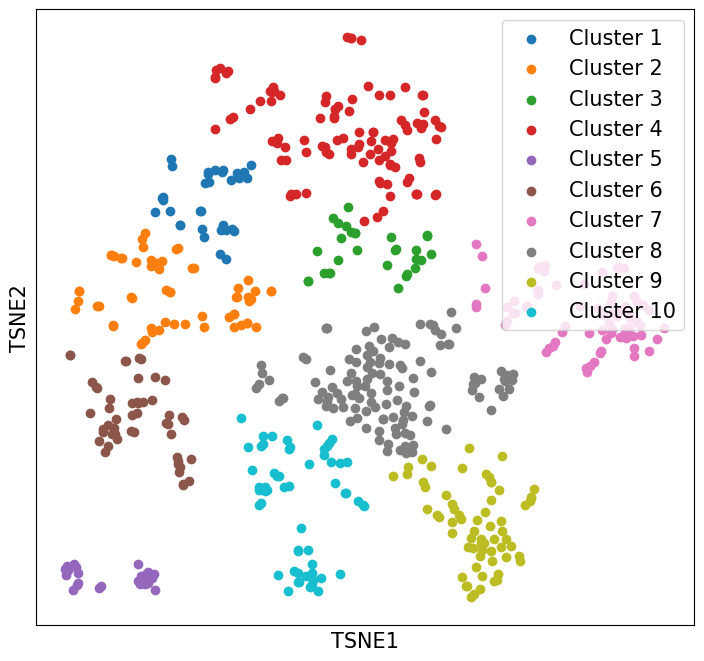

In [18]:
plot_features.plot_tsne_clusters(feature_space['TSNE1'], feature_space['TSNE2'], feature_space['tsne_ward_clusters'])

Find cluster centroids.

In [20]:
ligand_ids = feature_space.index
n_nearest_ligands = 5

centers = feature_space.groupby(feature_space['tsne_ward_clusters']).mean()
centroids = []

for cluster in range(0, n_clusters):
    array = np.asarray(centers[['TSNE1', 'TSNE2']].loc[centers.index == cluster+1])
    distances = pd.DataFrame(cdist(array, tsne_coordinates)).T
    sorted_distances = distances.sort_values(0)
    sorted_distances_new = sorted_distances.rename(columns={0: "Euclidian distance"})
    sorted_distances_new["ligand_id"] = ligand_ids[sorted_distances_new.index]
    final = sorted_distances_new.set_index("ligand_id")
    centroids.append(final.index[0])
    print(f"Cluster {cluster+1}, {n_nearest_ligands} ligands nearest to cluster centroid:\n")
    print(final.head(n_nearest_ligands))
    print("---------------------------------------\n")

Cluster 1, 5 ligands nearest to cluster centroid:

           Euclidian distance
ligand_id                    
469                  1.179873
751                  1.215696
305                  1.729187
299                  1.828047
733                  2.547442
---------------------------------------

Cluster 2, 5 ligands nearest to cluster centroid:

           Euclidian distance
ligand_id                    
153                  0.396001
167                  0.396045
166                  0.736747
409                  2.763827
556                  2.814356
---------------------------------------

Cluster 3, 5 ligands nearest to cluster centroid:

           Euclidian distance
ligand_id                    
70                   1.095041
414                  1.886469
117                  2.097731
422                  2.172458
121                  2.234917
---------------------------------------

Cluster 4, 5 ligands nearest to cluster centroid:

           Euclidian distance
ligand_id    

Plot centroids on feature space.

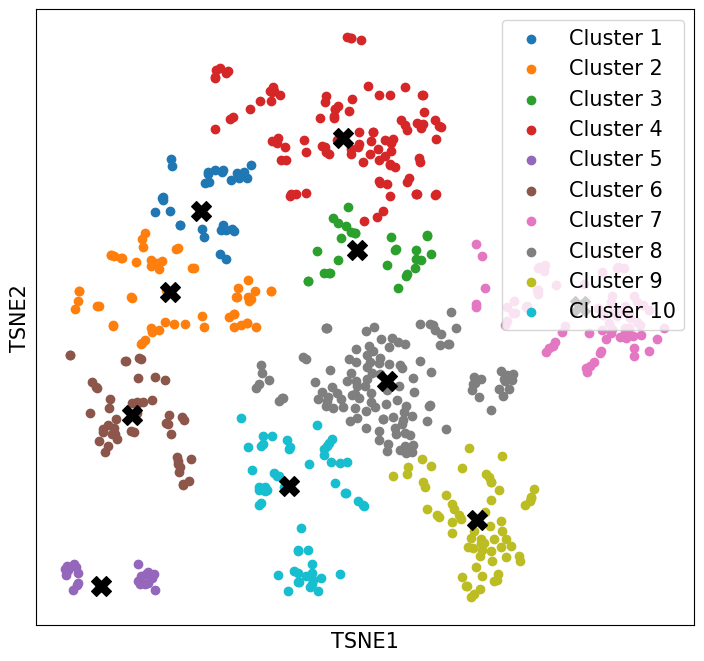

In [21]:
plot_features.plot_tsne_clusters(feature_space['TSNE1'], feature_space['TSNE2'], clusters=feature_space['tsne_ward_clusters'], centroids=centroids)

### 4.2. *k*-Means clustering of PCA space

Elbow method to guide the number of clusters to use.

In [22]:
pca_coordinates = feature_space[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

AutoElbow number of clusters: 5


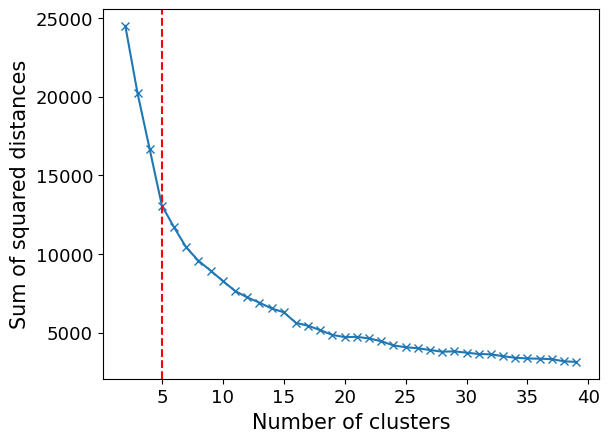

In [23]:
sum_of_squared_distances = []
K = range(2,40)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(pca_coordinates)
    sum_of_squared_distances.append(km.inertia_)

auto_elbow = autoelbow.auto_elbow_search(pca_coordinates)

print(f"AutoElbow number of clusters: {auto_elbow}")

plt.plot(K, sum_of_squared_distances, 'x-')
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.axvline(x=auto_elbow, linestyle='--', color='red')
plt.show()

Cluster with defined number (`n_clusters`).

In [24]:
n_clusters = 13

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_coordinates)
cluster_assignments = kmeans.labels_

Add cluster assignments to features dataframe.

In [25]:
feature_space['pca_kmeans_clusters'] = cluster_assignments

Plot clusters on PCA feature space.

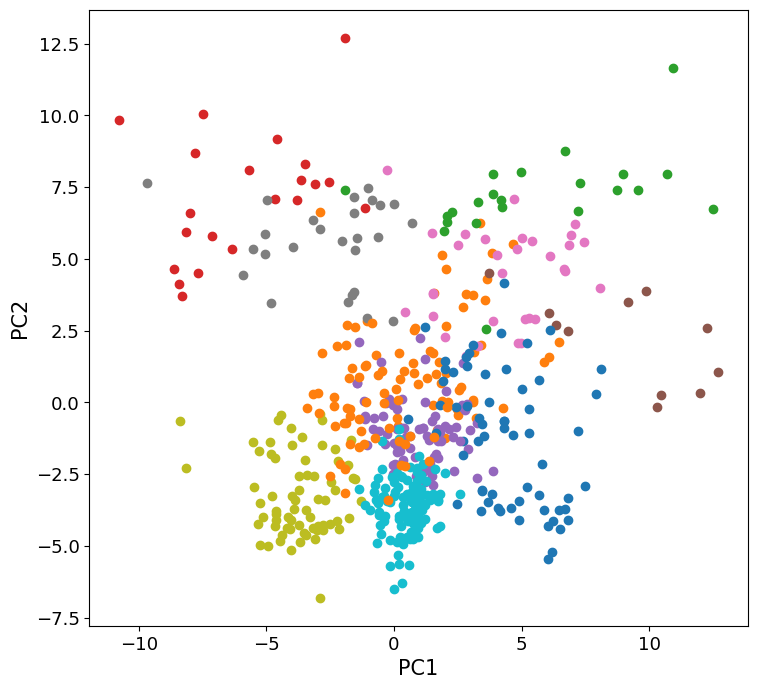

In [26]:
plot_features.plot_pca_clusters(feature_space['PC1'], feature_space['PC2'], feature_space['pca_kmeans_clusters'])

Find ligands closest to cluster centroids.

In [27]:
kmeans_df = pca_coordinates.copy()

def dist_to_center(line):
    delta = line[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] - kmeans.cluster_centers_[int(line['cluster'])]
    dist = np.linalg.norm(delta)
    return(dist)

kmeans_df["closest_to_center"] = 0
kmeans_df["cluster"] = kmeans.labels_
kmeans_df["distance_to_center"] = kmeans_df.apply(dist_to_center, axis = 1)

centroids = []
for clusternumber in range(n_clusters):
    min_to_center_idx = kmeans_df[kmeans_df["cluster"] == clusternumber]["distance_to_center"].idxmin()
    centroids.append(min_to_center_idx)
    kmeans_df.loc[min_to_center_idx, "closest_to_center"] = 1

Plot centroids on feature space.

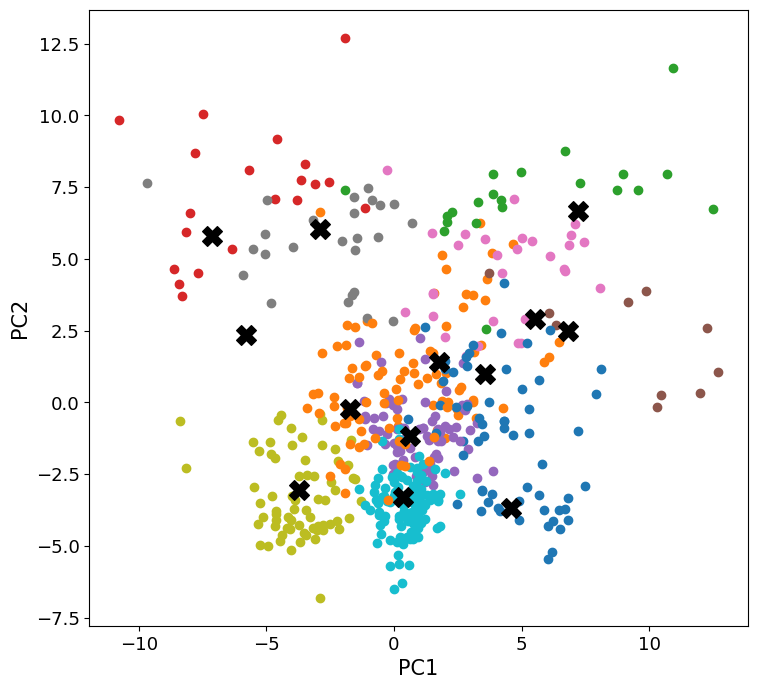

In [28]:
plot_features.plot_pca_clusters(feature_space['PC1'], feature_space['PC2'], clusters=feature_space['pca_kmeans_clusters'], centroids=centroids)

Save clusters to CSV file.

In [ ]:
feature_space.to_csv("clusters_tsne_pca.csv")

## 5. *t*-SNE cluster centroids in PCA space

Plot *t*-SNE cluster centroids in the PCA space.

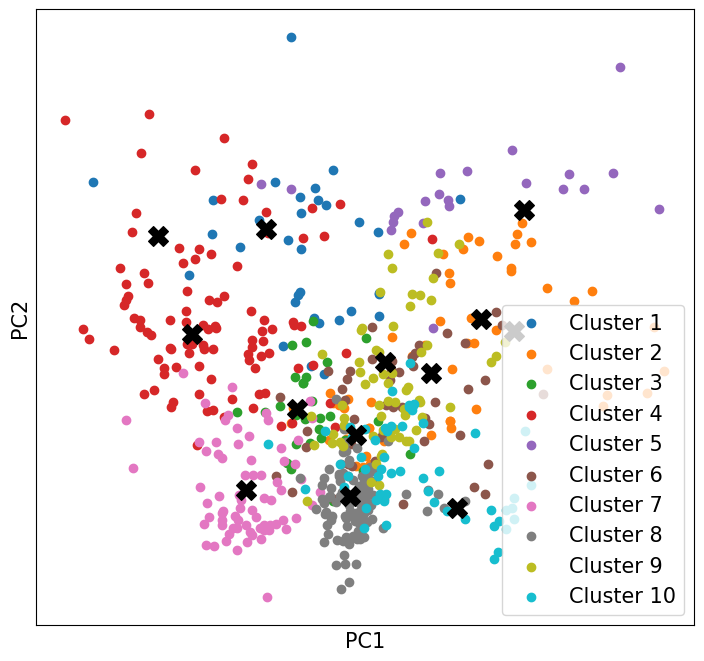

In [37]:
plot_features.plot_tsne_clusters(feature_space['PC1'], feature_space['PC2'], clusters=feature_space['tsne_ward_clusters'], centroids=centroids)

## 6. Chosen ligands in *t*-SNE and PCA feature spaces

In [30]:
chosen_ligands = [305, 480, 504, 70, 166, 382, 409, 498, 546, 584, 686, 823]

### 6.1. *t*-SNE feature space

Plot final ligand selection.

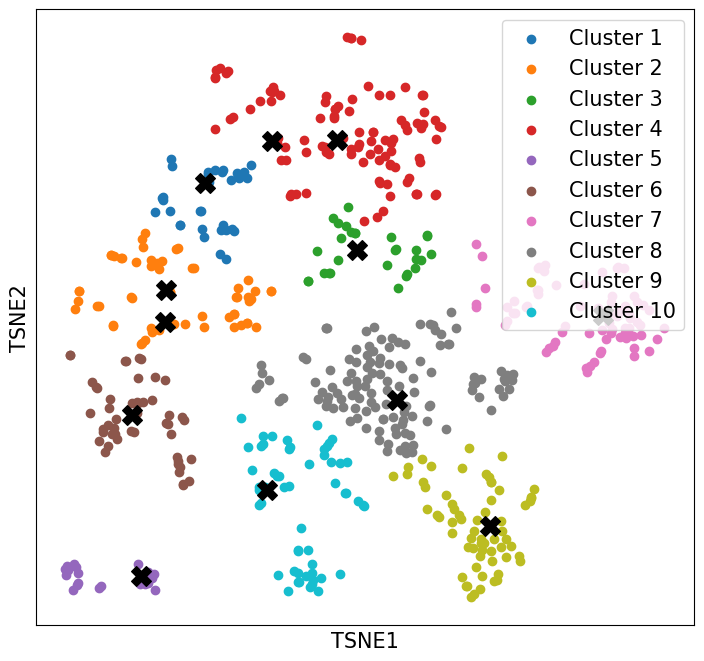

In [40]:
plot_features.plot_tsne_clusters(feature_space['TSNE1'], feature_space['TSNE2'], clusters=feature_space['tsne_ward_clusters'], centroids=chosen_ligands)

Generate cluster representation pie charts.

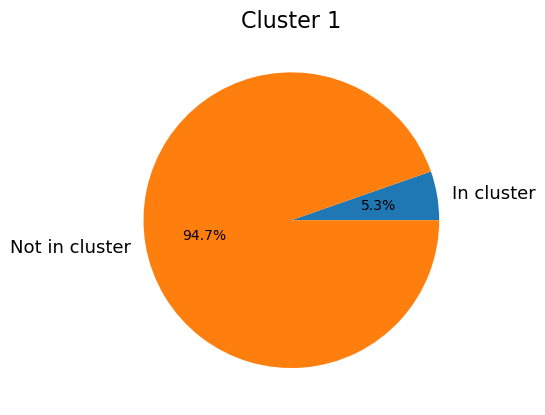

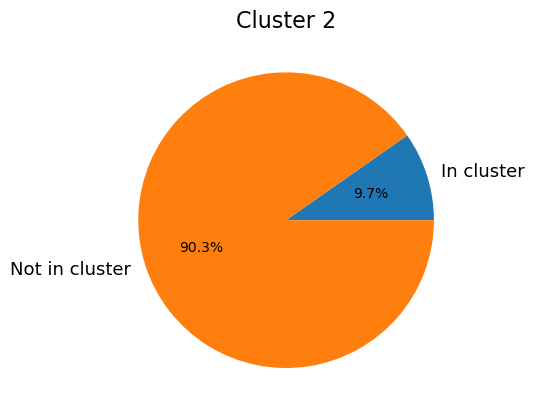

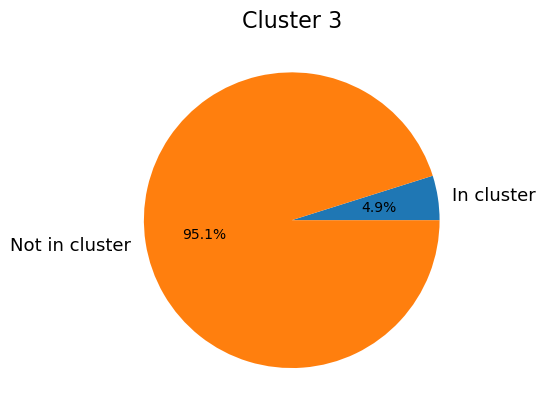

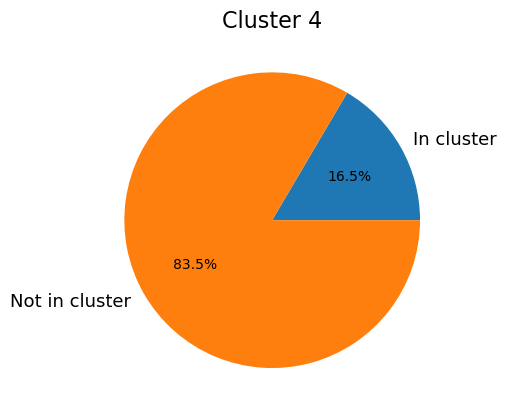

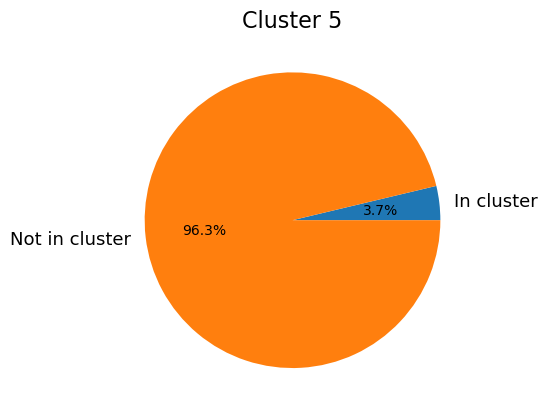

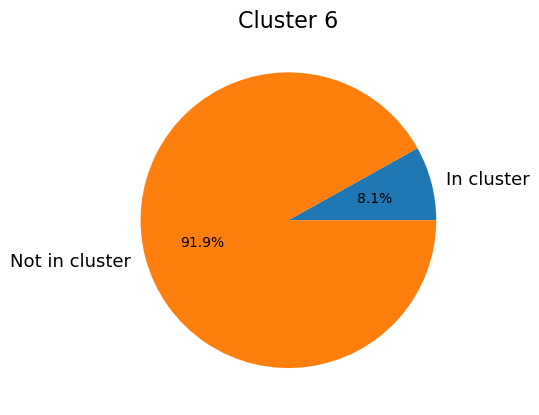

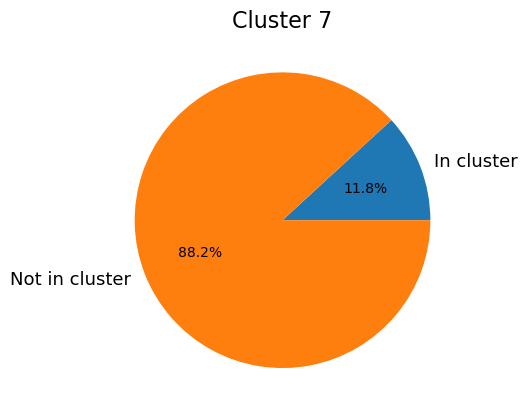

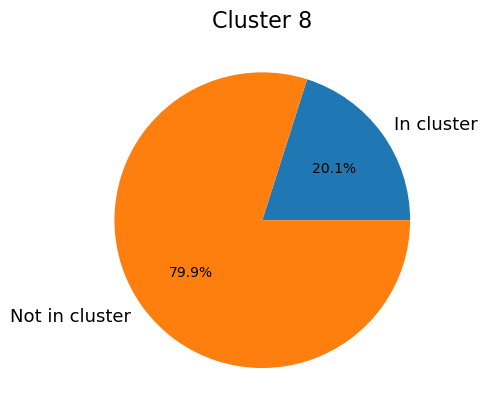

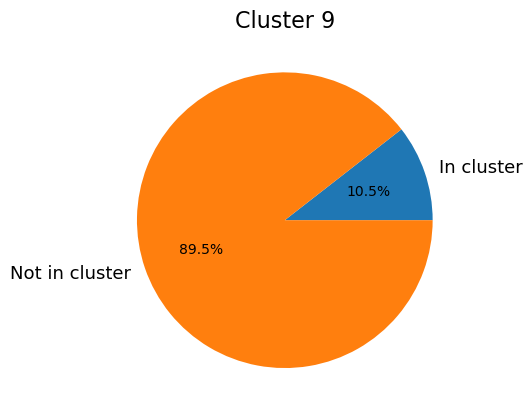

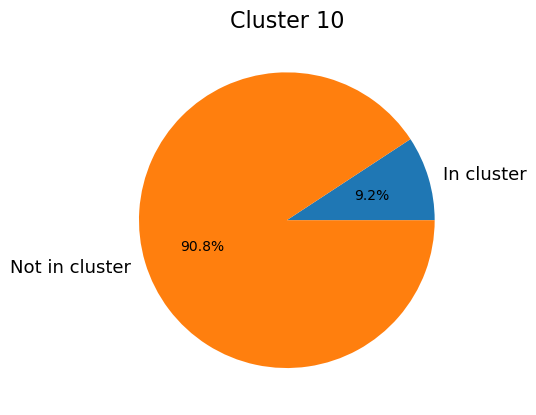

In [32]:
for i in range(0, len(feature_space['tsne_ward_clusters'].unique())):
    number_of_ligands = feature_space['tsne_ward_clusters'].value_counts()[i+1]
    total_ligands = len(feature_space)
    percentage = (number_of_ligands / total_ligands) * 100
    plt.title(f"Cluster {i+1}")
    plt.pie([number_of_ligands, (total_ligands-number_of_ligands)], labels=["In cluster", "Not in cluster"], autopct='%1.1f%%')
    plt.show()

Cluster coverage histogram.

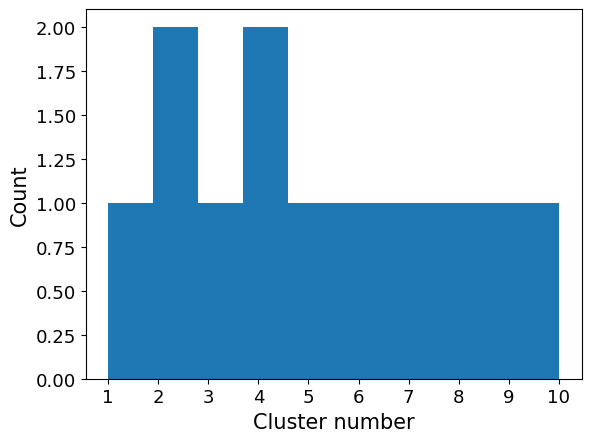

In [33]:
cluster_list = []

for ligand in chosen_ligands:
    cluster = feature_space['tsne_ward_clusters'][ligand]
    cluster_list.append(cluster)

plt.hist(cluster_list, bins=10)
plt.xlabel("Cluster number")
plt.ylabel("Count")
plt.xticks(np.arange(min(cluster_list), max(cluster_list)+1, 1.0))
plt.show()

### 6.2. PCA feature space

Plot ligands.

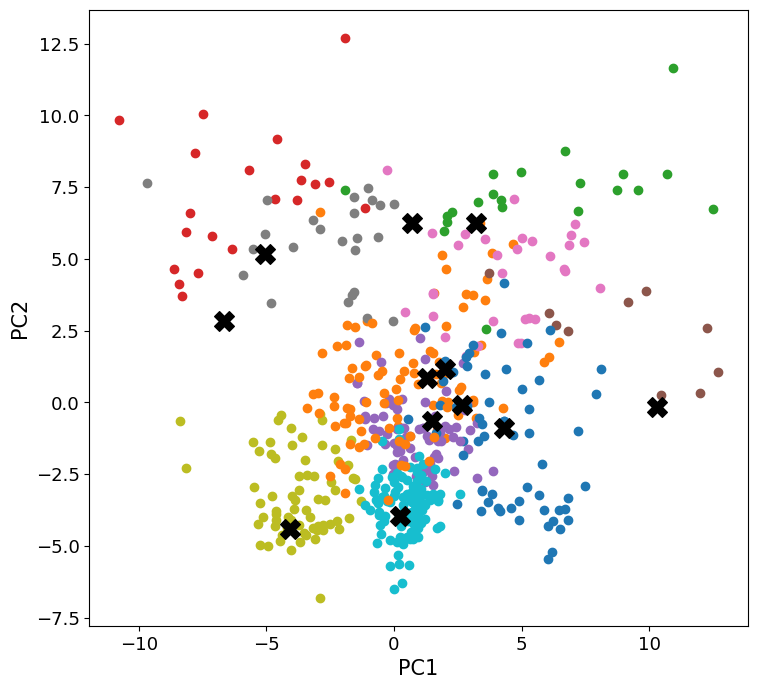

In [34]:
plot_features.plot_pca_clusters(feature_space['PC1'], feature_space['PC2'], clusters=feature_space['pca_kmeans_clusters'], centroids=chosen_ligands)

Generate cluster representation pie charts.

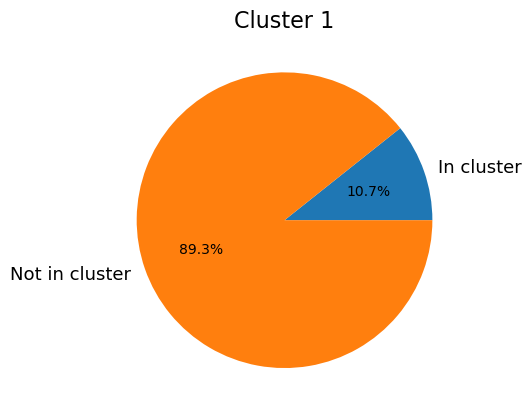

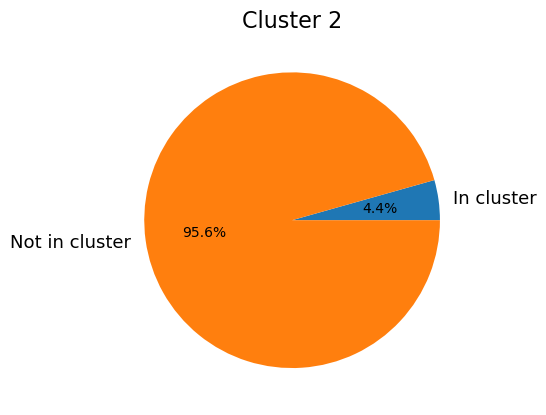

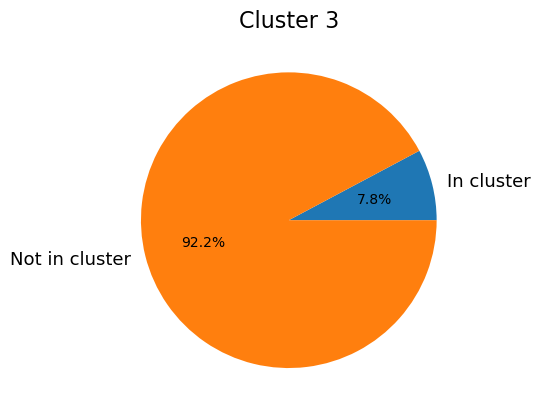

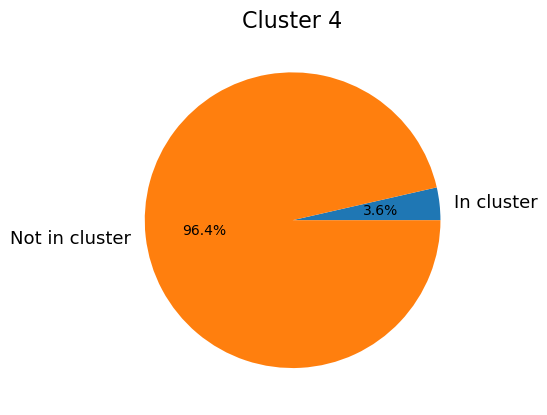

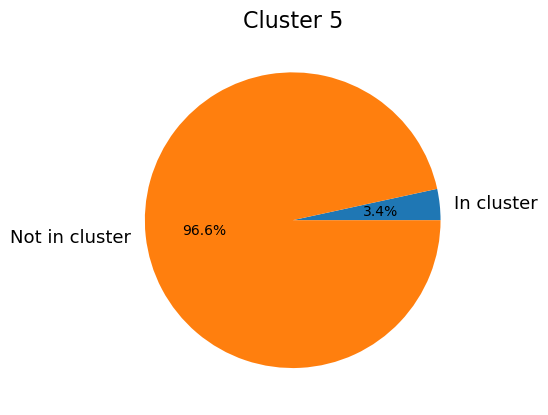

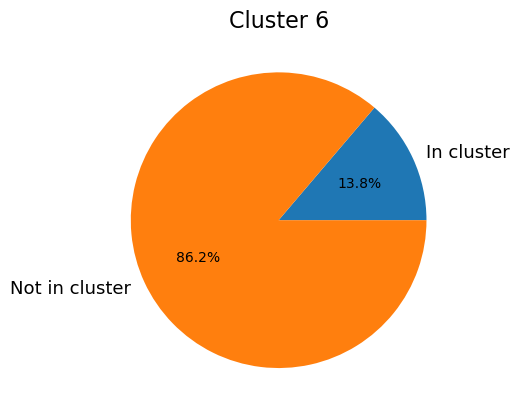

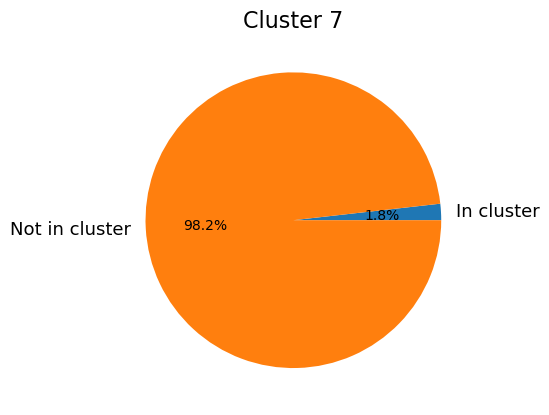

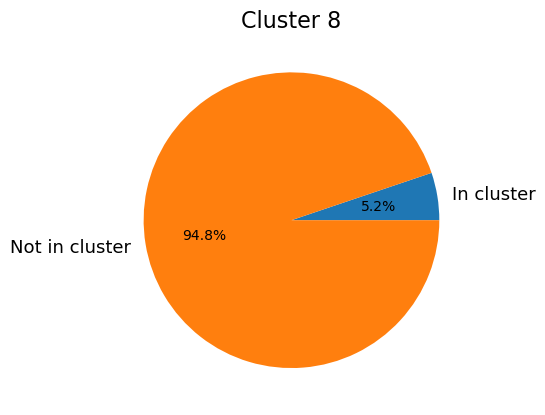

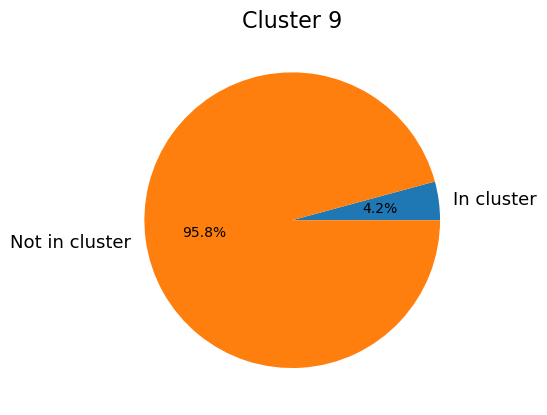

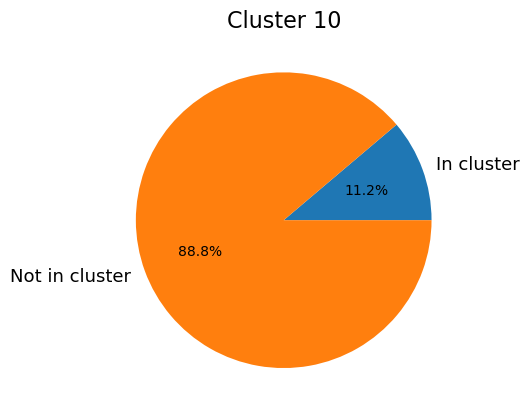

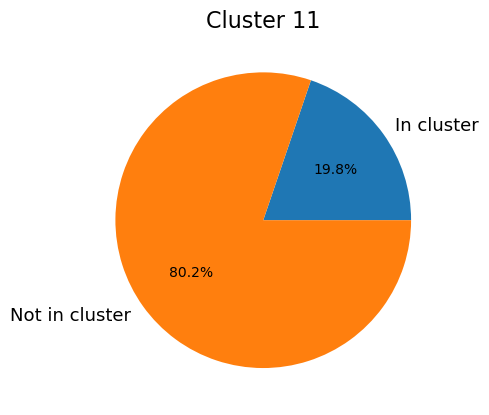

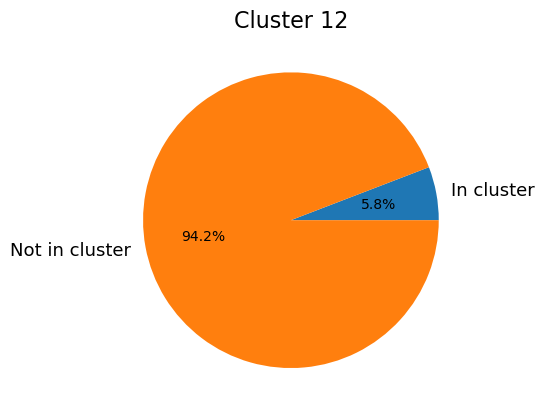

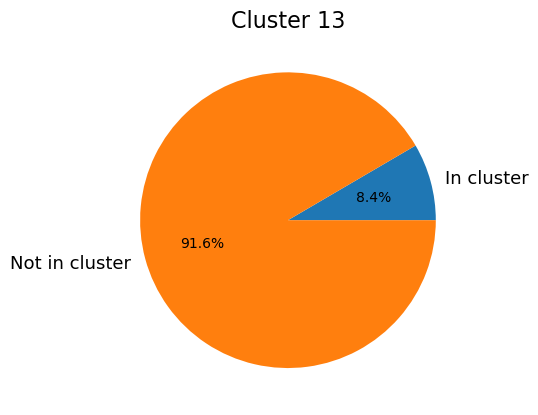

In [35]:
for i in range(0, len(feature_space['pca_kmeans_clusters'].unique())):
    number_of_ligands = feature_space['pca_kmeans_clusters'].value_counts()[i]
    total_ligands = len(feature_space)
    percentage = (number_of_ligands / total_ligands) * 100
    plt.title(f"Cluster {i+1}")
    plt.pie([number_of_ligands, (total_ligands-number_of_ligands)], labels=["In cluster", "Not in cluster"], autopct='%1.1f%%')
    plt.show()

Cluster coverage.

[9, 9, 12, 6, 12, 1, 7, 3, 4, 11, 10, 6]


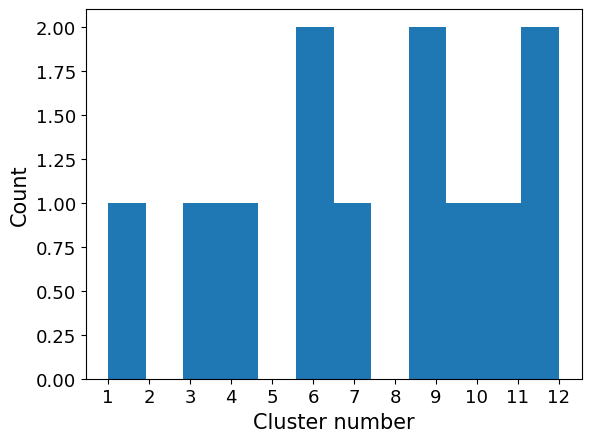

In [36]:
cluster_list = []

for ligand in chosen_ligands:
    cluster = feature_space['pca_kmeans_clusters'][ligand] + 1
    cluster_list.append(cluster)

print(cluster_list)

plt.hist(cluster_list, bins=12)
plt.xlabel("Cluster number")
plt.ylabel("Count")
plt.xticks(np.arange(min(cluster_list), max(cluster_list)+1, 1.0))
plt.show()